In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '2,3,4'

In [2]:
import sys

sys.path.append('/home/jovyan/mi-drive/medinfo_lab/Research_Projects/zhang/Husky/tools/')

In [3]:
import torch

from tqdm import tqdm
from Model.base.RoBERTa.char_sim import CharFuncs
from Model.base.RoBERTa.pretrain_config import FinetunePath, device, PronunciationPath, SentenceLength, TokenizerPath, test_data_path
from Model.base.RoBERTa.data.mlm_dataset import DataFactory, RobertaDataSet

In [4]:
model = FinetunePath + '.ep%d' % 7
tokenizer = TokenizerPath

In [5]:
model = torch.load(model)

In [6]:
from Model.base.RoBERTa.common.tokenizers import SpTokenizer

In [7]:
tokenizer = SpTokenizer(TokenizerPath)

In [8]:
from datasets import load_dataset

In [9]:
test_data = load_dataset("json", data_files = test_data_path)

In [10]:
test_data = test_data['train']

In [11]:
len(test_data['reference'])

1000

In [12]:
window_size = 510
def chunk_examples(examples):
    chunks = []
    for sentence in examples['reference']:
        chunks += [sentence[i:i+window_size] for i in range(0, len(sentence) - window_size + 1, 510)]
    return {"chunks": chunks}

In [13]:
test_data = test_data.map(chunk_examples, batched=True, remove_columns=test_data.column_names)

In [14]:
test_data

Dataset({
    features: ['chunks'],
    num_rows: 25059
})

In [15]:
data = RobertaDataSet(test_data['chunks'], onehot_type=False)

25059it [00:46, 534.33it/s]


has attension mask???

In [16]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset=data, batch_size=16, shuffle=True, drop_last=True)

In [17]:
def inferecne(input_token, segment_ids):
    with torch.no_grad():
        out = model(input_token, segment_ids)
    return out

In [18]:
from valuations.entropy import calculate_entropy

In [22]:
model.eval().to(device)
data_iter = tqdm(enumerate(dataloader),desc='eval',total=len(dataloader),bar_format='{l_bar}{r_bar}')
output = []
for i, data in data_iter:
    data = {k: v.to(device) for k, v in data.items()}
    input_token = data['token_ids_labels']
    segment_ids = data['segment_ids']
    mlm_output = inferecne(input_token, segment_ids)
    # print("mlm output shape:", mlm_output.shape)
    pooler = mlm_output.mean(dim=1).cpu()
    # print("Pooler output shape:", pooler.shape)
    ens = calculate_entropy(pooler, batch=True)
    input_token = input_token.tolist()
    texts = [tokenizer.decode(ids) for ids in input_token]
            
    for item in zip(ens, texts):
        output.append(item)

eval: 100%|| 1890/1890 [01:41<00:00, 18.59it/s]


In [30]:
len(output)

30240

In [37]:
for i in output:
    if i[0]<130:
        print(i)

(124.317154, ' ⁇  本日 の 採血 確認 し て ICT 先生 に も 治療 期間 について 確認 する 。 実施 日時 : 2023 - 05 - 03 10 : 46 : 57 血球 数 問題 なし 。 貧血 は 軽度 のみ 。 腎 障害 出現 なし 。 経過 は 順調 。 BP 105 / 79 HR 71 尿 量 3930 ml 就寝 中 CDDP 5 day 4 残 尿 エコー で < 100 ml 腹部 平坦 、 軟 創部 clear テープ が 剥がれ かけ 殿 部 に 接触 性 皮膚 炎 を 疑う 所見 あり 2023 / 04 / 07 TP 1 病理 結果 未着 ロピオン 事後 と 頓 用 で オーダー 術後 経過 よ さ そう 投与 基準 を 満たす 。 予約 日 : 2023 - 05 - 31 00 : 00 : 00 予約 日 : 2023 - 06 - 01 00 : 00 : 00 予約 日 : 2023 - 06 - 02 00 : 00 : 00 予約 日 : 2023 - 06 - 05 00 : 00 : 00 予約 日 : 2023 - 06 - 06 00 : 00 : 00 記事 日付 : 2023 / 06 / 05 定期 診察 少し 下痢 は あり ます 昨日 気づい た ん です けど 押す と 少し 痛い です 食欲 が あり すぎ ます 。 体調 いい です 。 痛い です 。 8 / 14 に Visit 1 を 予定 。 入院 中 に 、 コーディネーター の 来 棟 が ある こと を 伝え た 。 ステロイド の 副作用 による 不眠 出現 。 体温 最 ⁇ ')
(125.75475, ' ⁇  胸部 CT 検査 → PSL 計 15 mg タクロリムスカプセル 1 mg 「 VTRS 」 1 回 2 Cap 1 日 2 回 朝夕 食後 26 Cap アレンドロン 酸 錠 35 mg ( 週 1 回 製剤 )「 JG 」 1 回 1 錠 1 日 1 回 起床 時 < 日曜日 に 服用 > 1 錠 バイタルサイン 抗 MDA 5 抗体 陽性 皮膚 筋炎 + 間 質 性 肺炎 で PSL 18 mg + Tac : 4 mg + IVCY で 加療 中 の 38 歳 男性 MDA 5 抗体

In [33]:
for i in output:
    if i[0] > 300:
        print(i)

(333.35104, ' ⁇  750 EMG Endpoint ( sec ) 52 Base HR ( bpm ⁇ ')
(332.86517, ' ⁇  、 近 医 に ⁇ ')
(327.02768, ' ⁇ 挿入 し ない 。 入院 期間 も 月 単位 と なる 可能 性 ⁇ ')
(309.8275, ' ⁇  全て の 痂 皮 化 を 確認 し て い ます 。 以前 から アミラーゼ は 200 前後 と 軽度 高値 示し ⁇ ')
(325.63916, ' ⁇  部 硬直 なし 、 髄 膜 刺激 徴候 なし 、 肺 音 清 、 心音 整 , ⁇ ')
(326.6554, ' ⁇  の が 非 典型 的 。 変動 する 認知 機能 、 起立 性 低 血圧 など 踏まえる と レビー 小 体型 認知 症 も 鑑別 に 挙がる が 2021 年 6 ⁇ ')
(331.78925, ' ⁇ 外科 Dr より 術 前 ⁇ ')
(314.48978, ' ⁇  15 U / L ALT 10 U / L LD ( IFCC ) L 104 U / L ALP ( IFCC ) 65 U / L γ - GT 11 U / L TP L 6 . 4 g / dL ALB L 3 . 4 g / dL A / G L 1 . 13 T - Bil 0 . 5 mg / dL CRE ( eGFR ) 0 . 57 ( 80 . 0 ) mg / dL eGFR 80 . 0 mL / min / 1 . 73 m 2 UA H 5 ⁇ ')
(327.2311, ' ⁇  午前 高気圧 酸素 5 回 ⁇ ')
(314.57742, ' ⁇ た 。 寝付き が 悪かっ た 。 心配 事 、  ⁇ 女 が 今週 水曜日 に 来る 。 うれしい が 心配 で も ある 。  ⁇ 女 は 9 日間 滞在 。 最後 の 勤務 は 7 月 30 日 だ が 8 月 1 ⁇ ')
(326.85144, ' ⁇ 少し 切開 し 右 鼓膜 形成 術 予定 。 麻酔 科 術 前 診察 2014 / 06 / 11 口唇 形成 2015 / 03 / 04 口蓋 形成 術 + 両側 鼓膜 チューブ 留置 ⁇ ')
(345.0343, ' ⁇ 度 変更 し 、 早め に 

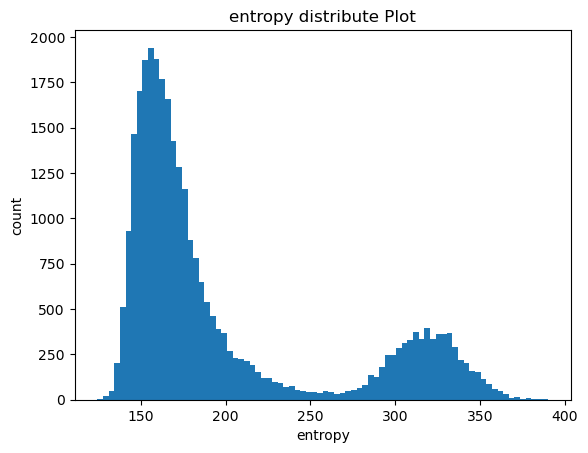

In [52]:
import matplotlib.pyplot as plt
entropy = []
for item in output:
    entropy.append(item[0])
plt.hist(entropy, bins=80)
plt.xlabel('entropy')
plt.ylabel('count')
plt.title('entropy distribute Plot')
plt.show()